In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from models.manifold_traversal import ManifoldTraversal

In [2]:
# load data
train_file = os.path.join('data', 'datawaves_100000_spinsFalse_nonuniform.npy')
test_file = os.path.join('data', 'datawaves_20000_spinsFalse_nonuniform.npy')

train_waves = np.load(train_file)
test_waves = np.load(test_file)

In [3]:
# prepare data
X_clean = train_waves.T#[:, :10000]  # use 10K samples for demo
X_test_clean = test_waves.T#[:, :2000]

# add noise
sigma = 0.01
np.random.seed(42)
X_noisy = X_clean + sigma * np.random.randn(*X_clean.shape)
X_test_noisy = X_test_clean + sigma * np.random.randn(*X_test_clean.shape)

D, N = X_clean.shape
print(f"Data loaded: {N} training samples, {D} dimensions")

Data loaded: 100000 training samples, 2048 dimensions


In [4]:
# creating manifold traversal network
mt = ManifoldTraversal(
    intrinsic_dim=2,
    ambient_dim=D,
    sigma=sigma,
    R_denoising=np.sqrt(8.0 * sigma**2 * D),
    R_1st_order_nbhd=np.sqrt(10.0 * sigma**2 * D),
    R_is_const=True,
    d_parallel=np.sqrt(20 * sigma**2 * 2),
    prod_coeff=2.0,
    exp_coeff=0.5
)

In [5]:
print('intrinsic_dim', mt.intrinsic_dim)
print('ambient_dim', mt.ambient_dim)
print('sigma', mt.sigma)
print('R_denoising', mt.R_denoising)
print('R_1st_order_nbhd', mt.R_1st_order_nbhd)
print('R_is_const', mt.R_is_const)
print('d_parallel', mt.d_parallel)
print('prod_coeff', mt.prod_coeff)
print('exp_coeff', mt.exp_coeff)

intrinsic_dim 2
ambient_dim 2048
sigma 0.01
R_denoising 1.28
R_1st_order_nbhd 1.4310835055998654
R_is_const True
d_parallel 0.06324555320336758
prod_coeff 2.0
exp_coeff 0.5


In [6]:
# train
results = mt.fit(X_noisy, X_clean, batch_size=2000, verbose=True)

Training manifold traversal on 100000 samples...
2000 samples processed (batch time: 0.73s)
4000 samples processed (batch time: 0.63s)
6000 samples processed (batch time: 0.64s)
8000 samples processed (batch time: 0.65s)
10000 samples processed (batch time: 0.68s)
12000 samples processed (batch time: 0.73s)
14000 samples processed (batch time: 0.95s)
16000 samples processed (batch time: 0.79s)
18000 samples processed (batch time: 0.80s)
20000 samples processed (batch time: 0.81s)
22000 samples processed (batch time: 0.81s)
24000 samples processed (batch time: 0.82s)
26000 samples processed (batch time: 0.81s)
28000 samples processed (batch time: 0.85s)
30000 samples processed (batch time: 0.82s)
32000 samples processed (batch time: 0.82s)
34000 samples processed (batch time: 0.82s)
36000 samples processed (batch time: 0.82s)
38000 samples processed (batch time: 0.82s)
40000 samples processed (batch time: 0.80s)
42000 samples processed (batch time: 0.85s)
44000 samples processed (batch 

In [7]:
# training results
print("="*60)
print("TRAINING RESULTS")
print("="*60)

print(f"Final mean squared denoising error: {results.mean_MT_error[-1]:.6f}")
print(f"Baseline error (noisy vs clean): {results.mean_data_error[-1]:.6f}")
print(f"Noise floor (σ²d): {sigma**2 * 2:.6f}")
print(f"Noise ceiling (σ²D): {sigma**2 * D:.6f}")

TRAINING RESULTS
Final mean squared denoising error: 0.026497
Baseline error (noisy vs clean): 0.204845
Noise floor (σ²d): 0.000200
Noise ceiling (σ²D): 0.204800


In [8]:
# network statistics
stats = mt.network.get_network_stats()
print(f"Network statistics:")
print(f"  Landmarks: {stats['num_landmarks']}")
print(f"  First-order edges: {stats['total_first_order_edges']}")
print(f"  Zero-order edges: {stats['total_zero_order_edges']}")
print(f"  Avg points per landmark: {stats['total_points_assigned'] / stats['num_landmarks']:.1f}")

Network statistics:
  Landmarks: 14
  First-order edges: 130
  Zero-order edges: 47
  Avg points per landmark: 7142.9


In [9]:
print("="*60)
print("TEST PERFORMANCE")
print("="*60)

# analyze performance on test data
test_results = mt.analyze_performance(X_test_noisy, X_test_clean, num_samples=500)

print("Performance comparison:")
print(f"  Exhaustive Search: Error={test_results['exhaustive']['avg_distance']:.6f}, "
      f"Complexity={test_results['exhaustive']['avg_mults']:.0f} mults/sample")
print(f"  Manifold Traversal: Error={test_results['mixed_order']['avg_distance']:.6f}, "
      f"Complexity={test_results['mixed_order']['avg_mults']:.0f} mults/sample")

speedup = test_results['exhaustive']['avg_mults'] / test_results['mixed_order']['avg_mults']
error_increase = (test_results['mixed_order']['avg_distance'] - test_results['exhaustive']['avg_distance']) / test_results['exhaustive']['avg_distance'] * 100

print(f"\nSpeedup: {speedup:.1f}x faster")
print(f"Error increase: {error_increase:.1f}%")

TEST PERFORMANCE
Performance comparison:
  Exhaustive Search: Error=0.098442, Complexity=28672 mults/sample
  Manifold Traversal: Error=0.103056, Complexity=25575 mults/sample

Speedup: 1.1x faster
Error increase: 4.7%


In [10]:
print("="*60)
print("NETWORK STRUCTURE")
print("="*60)

# access internal network structure
landmarks = mt.network.landmarks

print(f"Network has {len(landmarks)} landmarks:")
for i, landmark in enumerate(landmarks[:5]):  # Show first 5
    print(f"  Landmark {i+1}: {landmark.point_count} points, "
          f"{len(landmark.first_order_edges)} first-order edges")
if len(landmarks) > 5:
    print(f"  ... and {len(landmarks) - 5} more landmarks")

NETWORK STRUCTURE
Network has 14 landmarks:
  Landmark 1: 25857 points, 9 first-order edges
  Landmark 2: 16757 points, 8 first-order edges
  Landmark 3: 22511 points, 8 first-order edges
  Landmark 4: 13372 points, 8 first-order edges
  Landmark 5: 5424 points, 11 first-order edges
  ... and 9 more landmarks


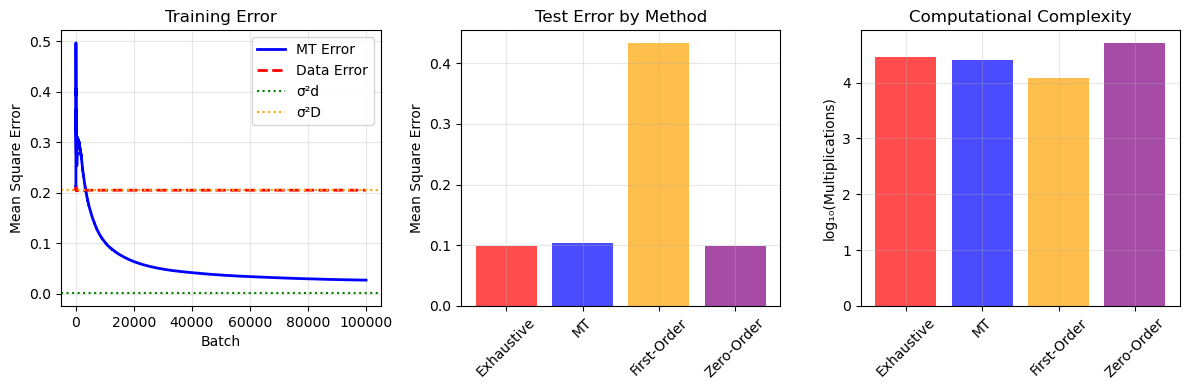

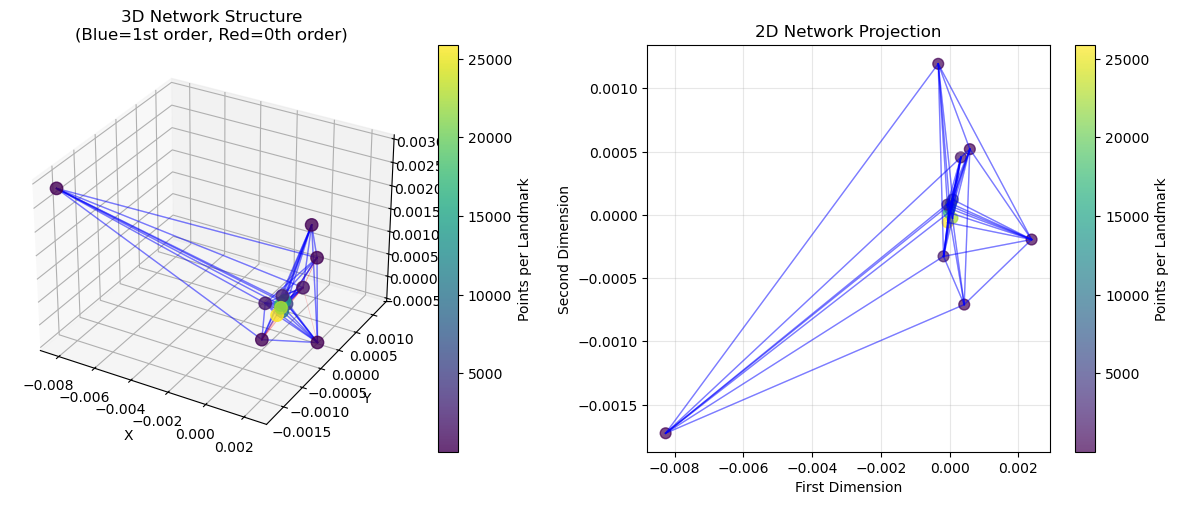

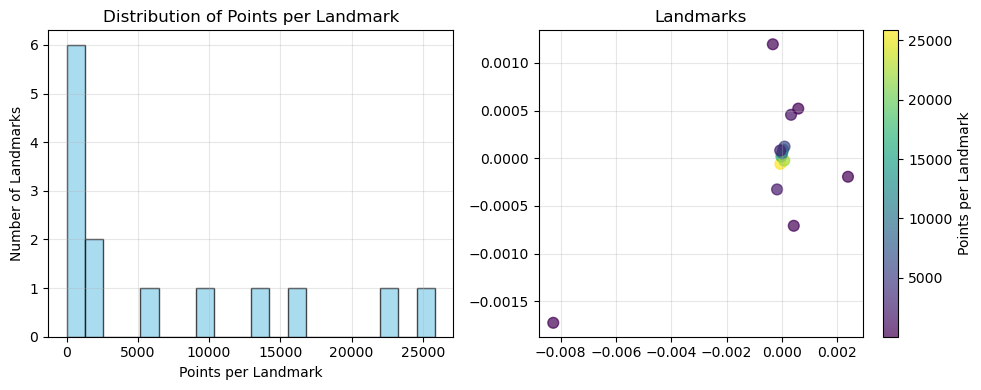

In [11]:
# 1. Training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(results.mean_MT_error, 'b-', label='MT Error', linewidth=2)
plt.plot(results.mean_data_error, 'r--', label='Data Error', linewidth=2)
plt.axhline(y=sigma**2 * 2, color='g', linestyle=':', label=f'σ²d')
plt.axhline(y=sigma**2 * D, color='orange', linestyle=':', label=f'σ²D')
plt.xlabel('Batch')
plt.ylabel('Mean Square Error')
plt.title('Training Error')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Performance comparison
plt.subplot(1, 3, 2)
methods = ['Exhaustive', 'MT', 'First-Order', 'Zero-Order']
errors = [test_results[key]['avg_distance'] for key in ['exhaustive', 'mixed_order', 'first_order_only', 'zero_order_only']]
colors = ['red', 'blue', 'orange', 'purple']
plt.bar(methods, errors, color=colors, alpha=0.7)
plt.ylabel('Mean Square Error')
plt.title('Test Error by Method')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Complexity comparison
plt.subplot(1, 3, 3)
complexities = [test_results[key]['avg_mults'] for key in ['exhaustive', 'mixed_order', 'first_order_only', 'zero_order_only']]
plt.bar(methods, np.log10(complexities), color=colors, alpha=0.7)
plt.ylabel('log₁₀(Multiplications)')
plt.title('Computational Complexity')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Network visualization
mt.network.visualize(show_edges=True)

# 5. Landmark distribution
point_counts = [landmark.point_count for landmark in landmarks]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(point_counts, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Points per Landmark')
plt.ylabel('Number of Landmarks')
plt.title('Distribution of Points per Landmark')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
landmark_positions = mt.network.get_landmark_positions()
plt.scatter(landmark_positions[0, :], landmark_positions[1, :], 
           c=point_counts, cmap='viridis', s=60, alpha=0.7)
plt.colorbar(label='Points per Landmark')
plt.title('Landmarks')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
print("="*60)
print("SINGLE SAMPLE DENOISING DEMONSTRATION")
print("="*60)

# pick a test sample for demonstration
demo_idx = 0
x_clean_demo = X_test_clean[:, demo_idx]
x_noisy_demo = X_test_noisy[:, demo_idx]

# denoise using trained network
x_denoised_demo = mt.denoise(x_noisy_demo)

# compute corr
correlation_denoised = np.corrcoef(x_denoised_demo, x_clean_demo)[0, 1]

print(f"Correlation (denoised vs clean): {correlation_denoised:.4f}")

SINGLE SAMPLE DENOISING DEMONSTRATION
Correlation (denoised vs clean): 0.9972


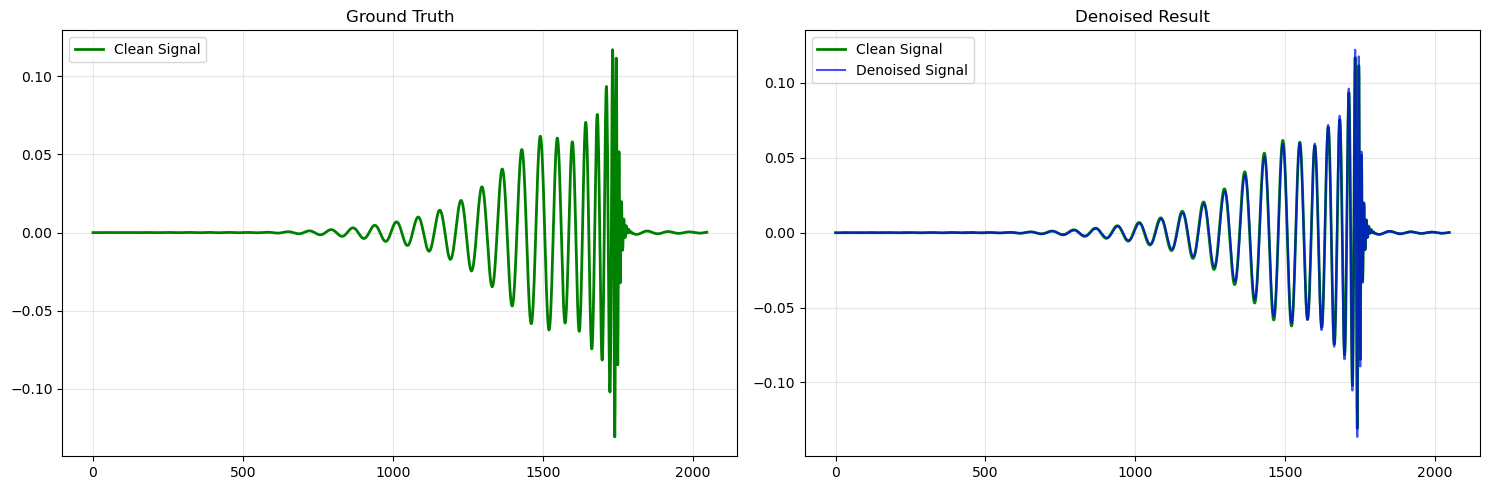

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x_clean_demo, 'g-', linewidth=2, label='Clean Signal')
plt.title('Ground Truth')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_clean_demo, 'g-', linewidth=2, label='Clean Signal')
plt.plot(x_denoised_demo, 'b-', alpha=0.7, label='Denoised Signal')
plt.title(f'Denoised Result')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()